In [ ]:
import pandas as pd
import os
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from scipy.stats import median_abs_deviation
import warnings

In [ ]:
base_dir = os.getcwd()
ruta_path = os.path.join(
    base_dir, "..", "data", "processed","Madrid", "datos_Madrid_horarios_transformado.csv"
)
df = pd.read_csv(ruta_path)

In [3]:
df.columns

Index(['date', 'temperature_2m', 'relative_humidity_2m', 'precipitation',
       'wind_speed_10m'],
      dtype='object')

## TRATAMIENTO DE OUTLIERS
### TEMPERATURA

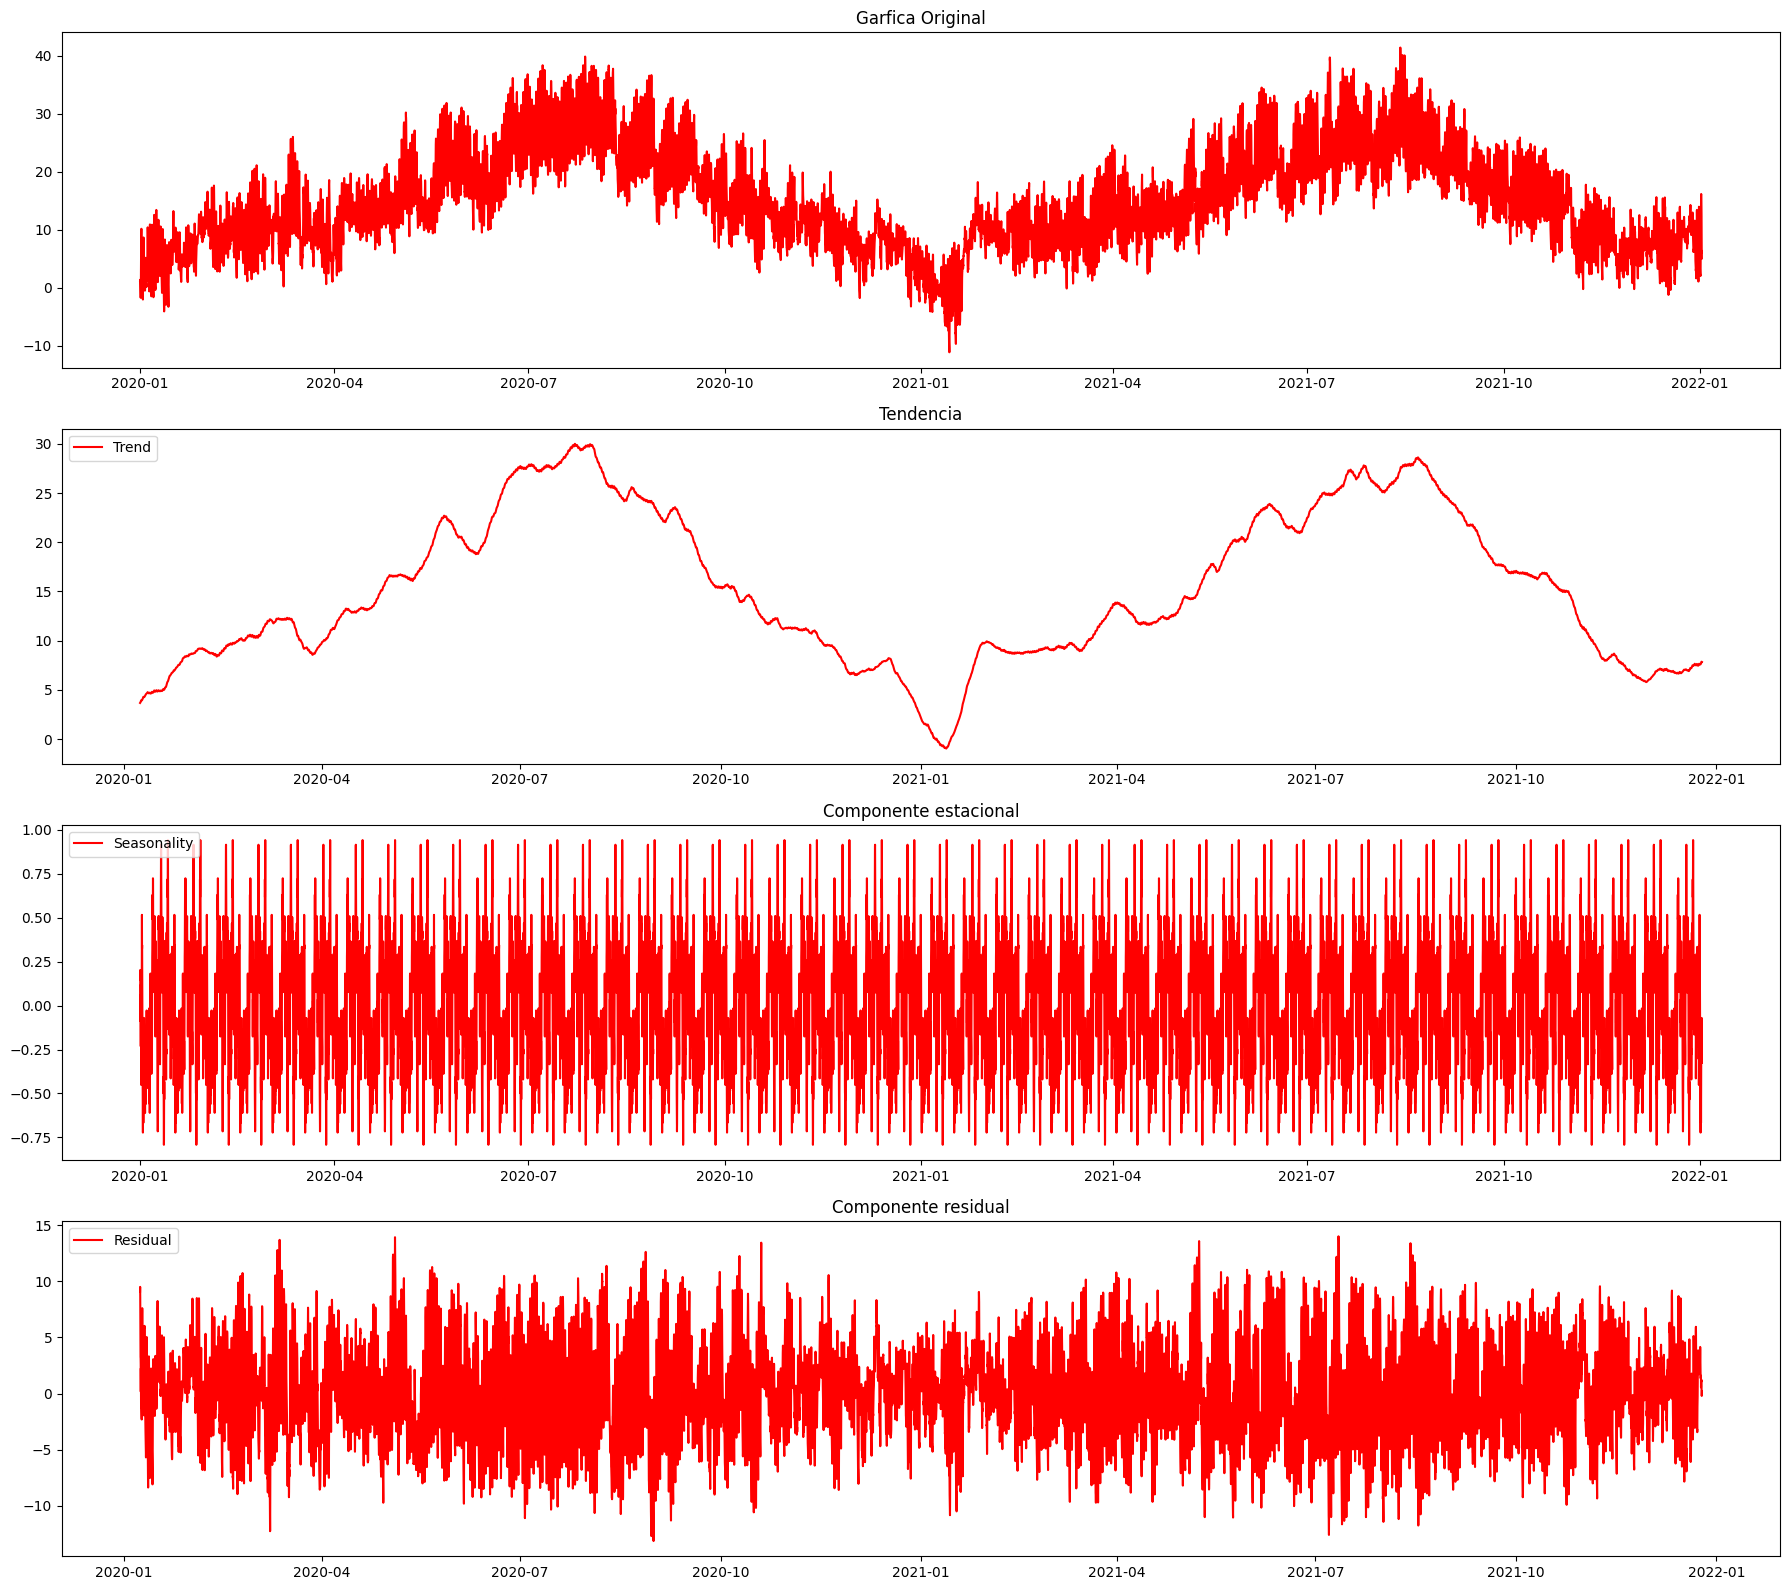

In [4]:
df["date"] = pd.to_datetime(df["date"])
# Descomponer la serie tenporal de la temperatura para mostrar la tendencia, estacionalidad y residuos
decomposition_temp = seasonal_decompose(df["temperature_2m"], model='additive', period=365)


plt.figure(figsize=(18, 16))

plt.subplot(4, 1, 1)
plt.plot(df["date"], df["temperature_2m"], color="red")
plt.title('Garfica Original')

plt.subplot(4, 1, 2)
plt.plot(df["date"], decomposition_temp.trend, label='Trend', color="red")
plt.legend(loc='upper left')
plt.title('Tendencia')

plt.subplot(4, 1, 3)
plt.plot(df["date"], decomposition_temp.seasonal, label='Seasonality', color="red")
plt.legend(loc='upper left')
plt.title('Componente estacional')

plt.subplot(4, 1, 4)
plt.plot(df["date"], decomposition_temp.resid, label='Residual', color="red")
plt.legend(loc='upper left')
plt.title('Componente residual')

plt.tight_layout()
plt.show()

### DETECCIÓN DE OUTLIERS MEDIANTE EL FILTRO HAMPEL

- Detecta los outliers dentro de una ventana utlizando la mediana ya que la mediana no suele ser muy afectada por outliers.

In [5]:
window_size=30
n_sigma=3

#Calculate the median in a rolling centered window
rolling_median = df["temperature_2m"].rolling(window_size, center=True).median()

#Calculate the median of the absolute deviations from the data’s median in a rolling centered window
mad = df["temperature_2m"].rolling(window_size, center=True).apply(median_abs_deviation)

#Treshold 
threshold_min = rolling_median - n_sigma*mad
threshold_max = rolling_median + n_sigma*mad

df["outlier_hm"] = (np.abs(df["temperature_2m"] - rolling_median) > n_sigma*mad)

In [6]:
threshold_max

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
17563   NaN
17564   NaN
17565   NaN
17566   NaN
17567   NaN
Name: temperature_2m, Length: 17568, dtype: float64

- Outliers del año 2020.

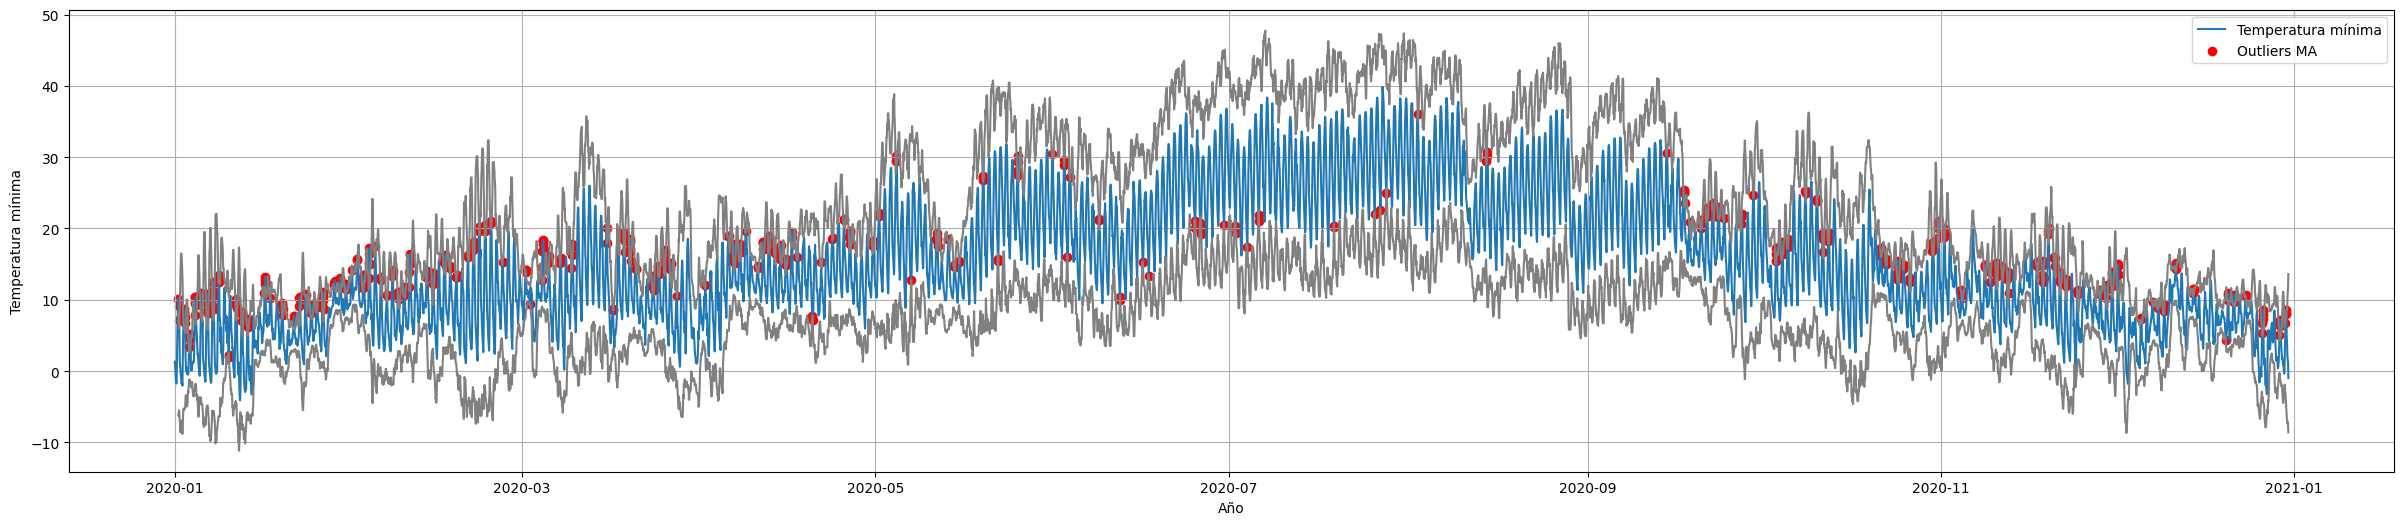

In [7]:
plt.figure(figsize=(30, 6))

primer_año = df.loc[df["date"] <= "2020-12-31"]
plt.plot(primer_año['date'], primer_año['temperature_2m'], label='Temperatura mínima')
plt.plot(primer_año['date'], threshold_min[:8761], color='gray')
plt.plot(primer_año['date'], threshold_max[:8761], color='gray')

plt.scatter(primer_año["date"][df["outlier_hm"]], primer_año["temperature_2m"][primer_año["outlier_hm"]], color='red', label="Outliers MA")
plt.xlabel('Año')
plt.ylabel('Temperatura mínima')
plt.legend()
plt.grid(True)
plt.show()


- Outliers del año 2021.

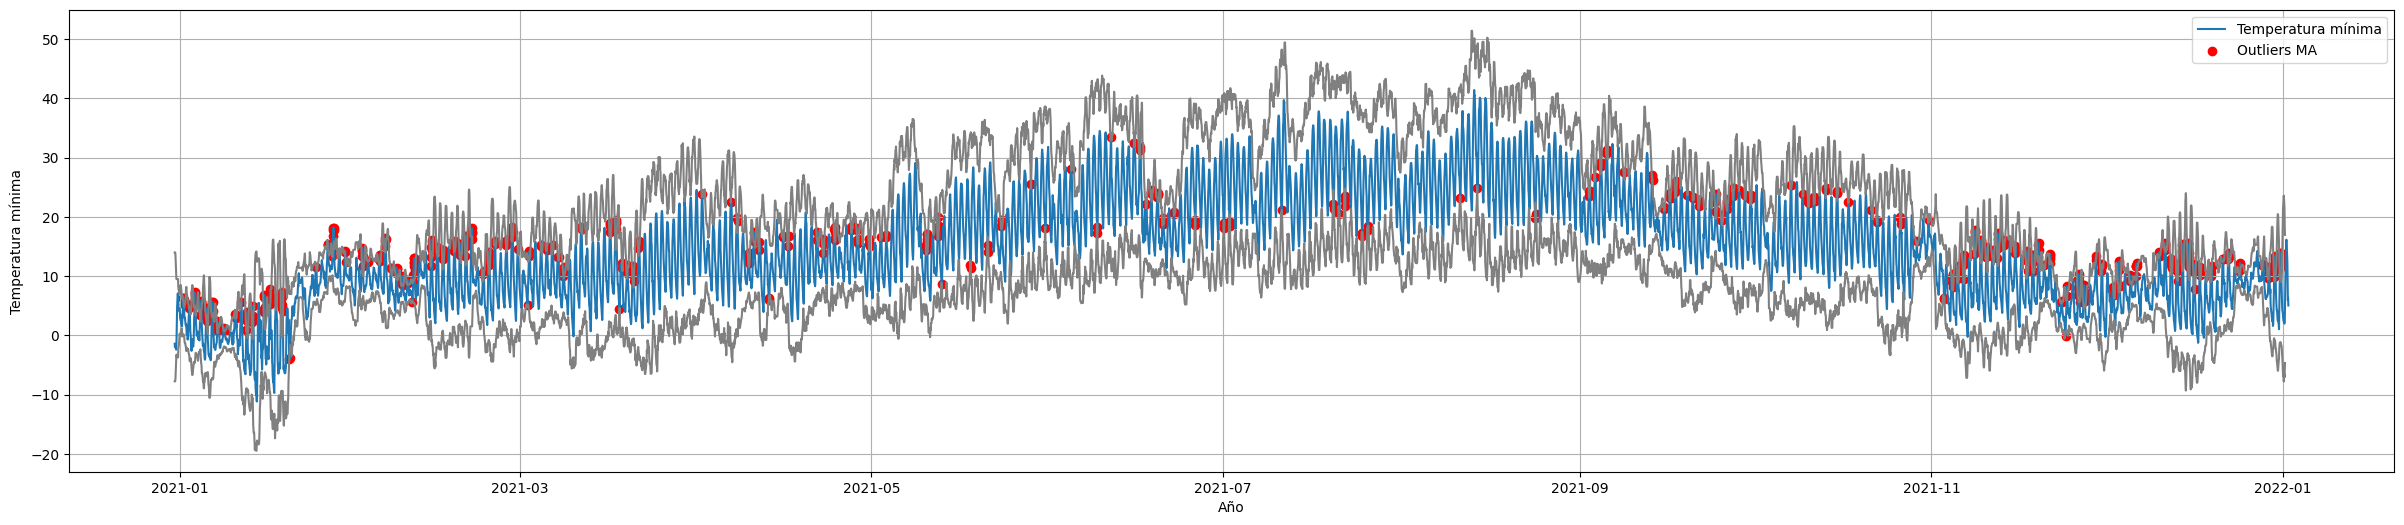

In [8]:

plt.figure(figsize=(30, 6))

segundo_año = df.loc[df["date"] > "2020-12-31"]
plt.plot(segundo_año['date'], segundo_año['temperature_2m'], label='Temperatura mínima')
plt.plot(segundo_año['date'], threshold_min[8761:], color='gray')
plt.plot(segundo_año['date'], threshold_max[8761:], color='gray')

plt.scatter(segundo_año["date"][df["outlier_hm"]], segundo_año["temperature_2m"][segundo_año["outlier_hm"]], color='red', label="Outliers MA")
plt.xlabel('Año')
plt.ylabel('Temperatura mínima')
plt.legend()
plt.grid(True)
plt.show()

- Se detectan los outliers y se les imputa el valor calculado anteriormente, que esta representado como la linea gris.

In [9]:
# Imputar los outliers para que no superen el umbral
df["temp_imputed"] = df["temperature_2m"].copy()  # Copiar la columna original

# Reemplazar valores por debajo del umbral mínimo con el umbral mínimo
df.loc[df["temperature_2m"] < threshold_min, "temp_imputed"] = threshold_min

# Reemplazar valores por encima del umbral máximo con el umbral máximo
df.loc[df["temperature_2m"] > threshold_max, "temp_imputed"] = threshold_max

- Muestra de 6 meses donde se ve los valores que se han imputado.

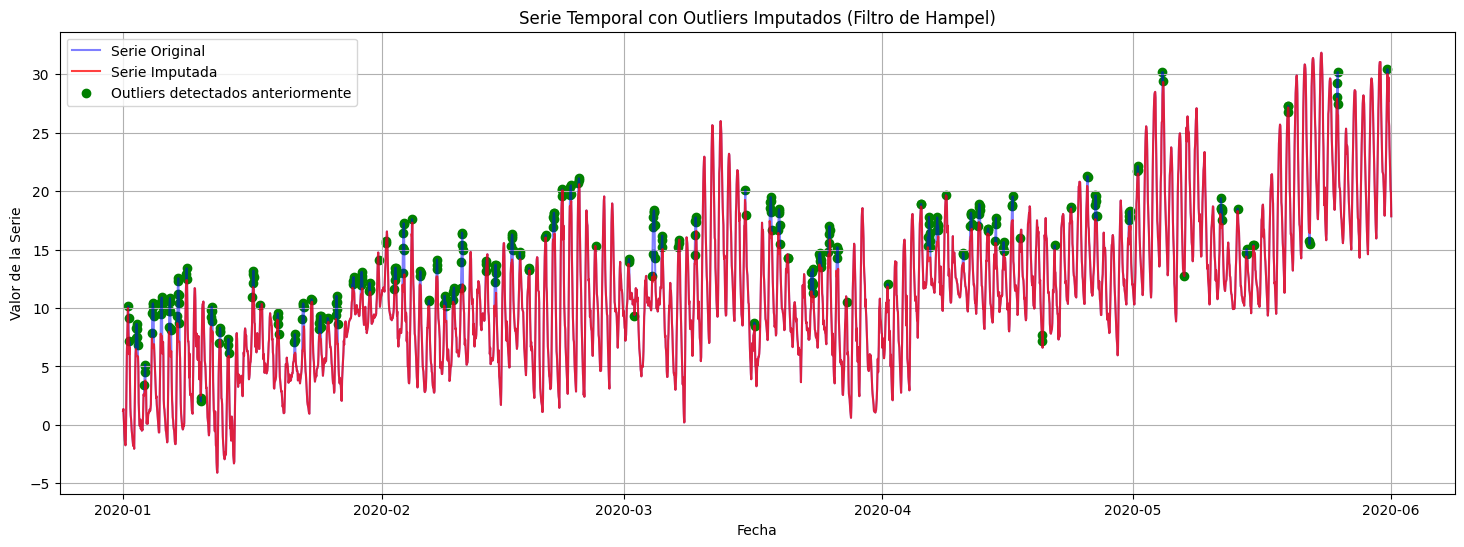

In [10]:
# Muestra de 6 meses
plt.figure(figsize=(18, 6))

mitad_2020 = df.loc[df["date"] <= "2020-06-01"]
# Serie temporal original
plt.plot(mitad_2020["date"], mitad_2020["temperature_2m"], label="Serie Original", color="blue", alpha=0.5)

# Serie temporal con outliers imputados
plt.plot(mitad_2020["date"], mitad_2020["temp_imputed"], label="Serie Imputada", color="red", alpha=0.75)

# Valores atípicos
outliers = mitad_2020[mitad_2020["outlier_hm"]]
plt.scatter(outliers["date"], outliers["temperature_2m"], color="green", label="Outliers detectados anteriormente")


plt.title("Serie Temporal con Outliers Imputados (Filtro de Hampel)")
plt.xlabel("Fecha")
plt.ylabel("Valor de la Serie")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
df["temperature"] = df["temp_imputed"]
df.drop(columns=["outlier_hm","temp_imputed","temperature_2m"], inplace = True)

### Comprobar si los datos son estacionarios

- El test de dickey duller detecta si existe una raíz unitaria en la serie temporal. Si la hay significa que no es estacionaria.

In [12]:
# Realizar el Test ADF (Dickey-Fuller Aumentado)
adf_result = adfuller(df["temperature"])

# Imprimir los resultados del test ADF
print("Estadística de prueba ADF:", adf_result[0])
print("Valor p:", adf_result[1])
print("Valores críticos:", adf_result[4])

# Interpretación del resultado
if adf_result[1] < 0.05:
    print("Rechazamos la hipótesis nula: La serie es estacionaria")
else:
    print("No podemos rechazar la hipótesis nula: La serie tiene una raíz unitaria y no es estacionaria")

Estadística de prueba ADF: -3.151854998983533
Valor p: 0.022946184180333704
Valores críticos: {'1%': -3.430723238497956, '5%': -2.861704957013964, '10%': -2.5668578023342805}
Rechazamos la hipótesis nula: La serie es estacionaria


## HUMEDAD RELATIVA

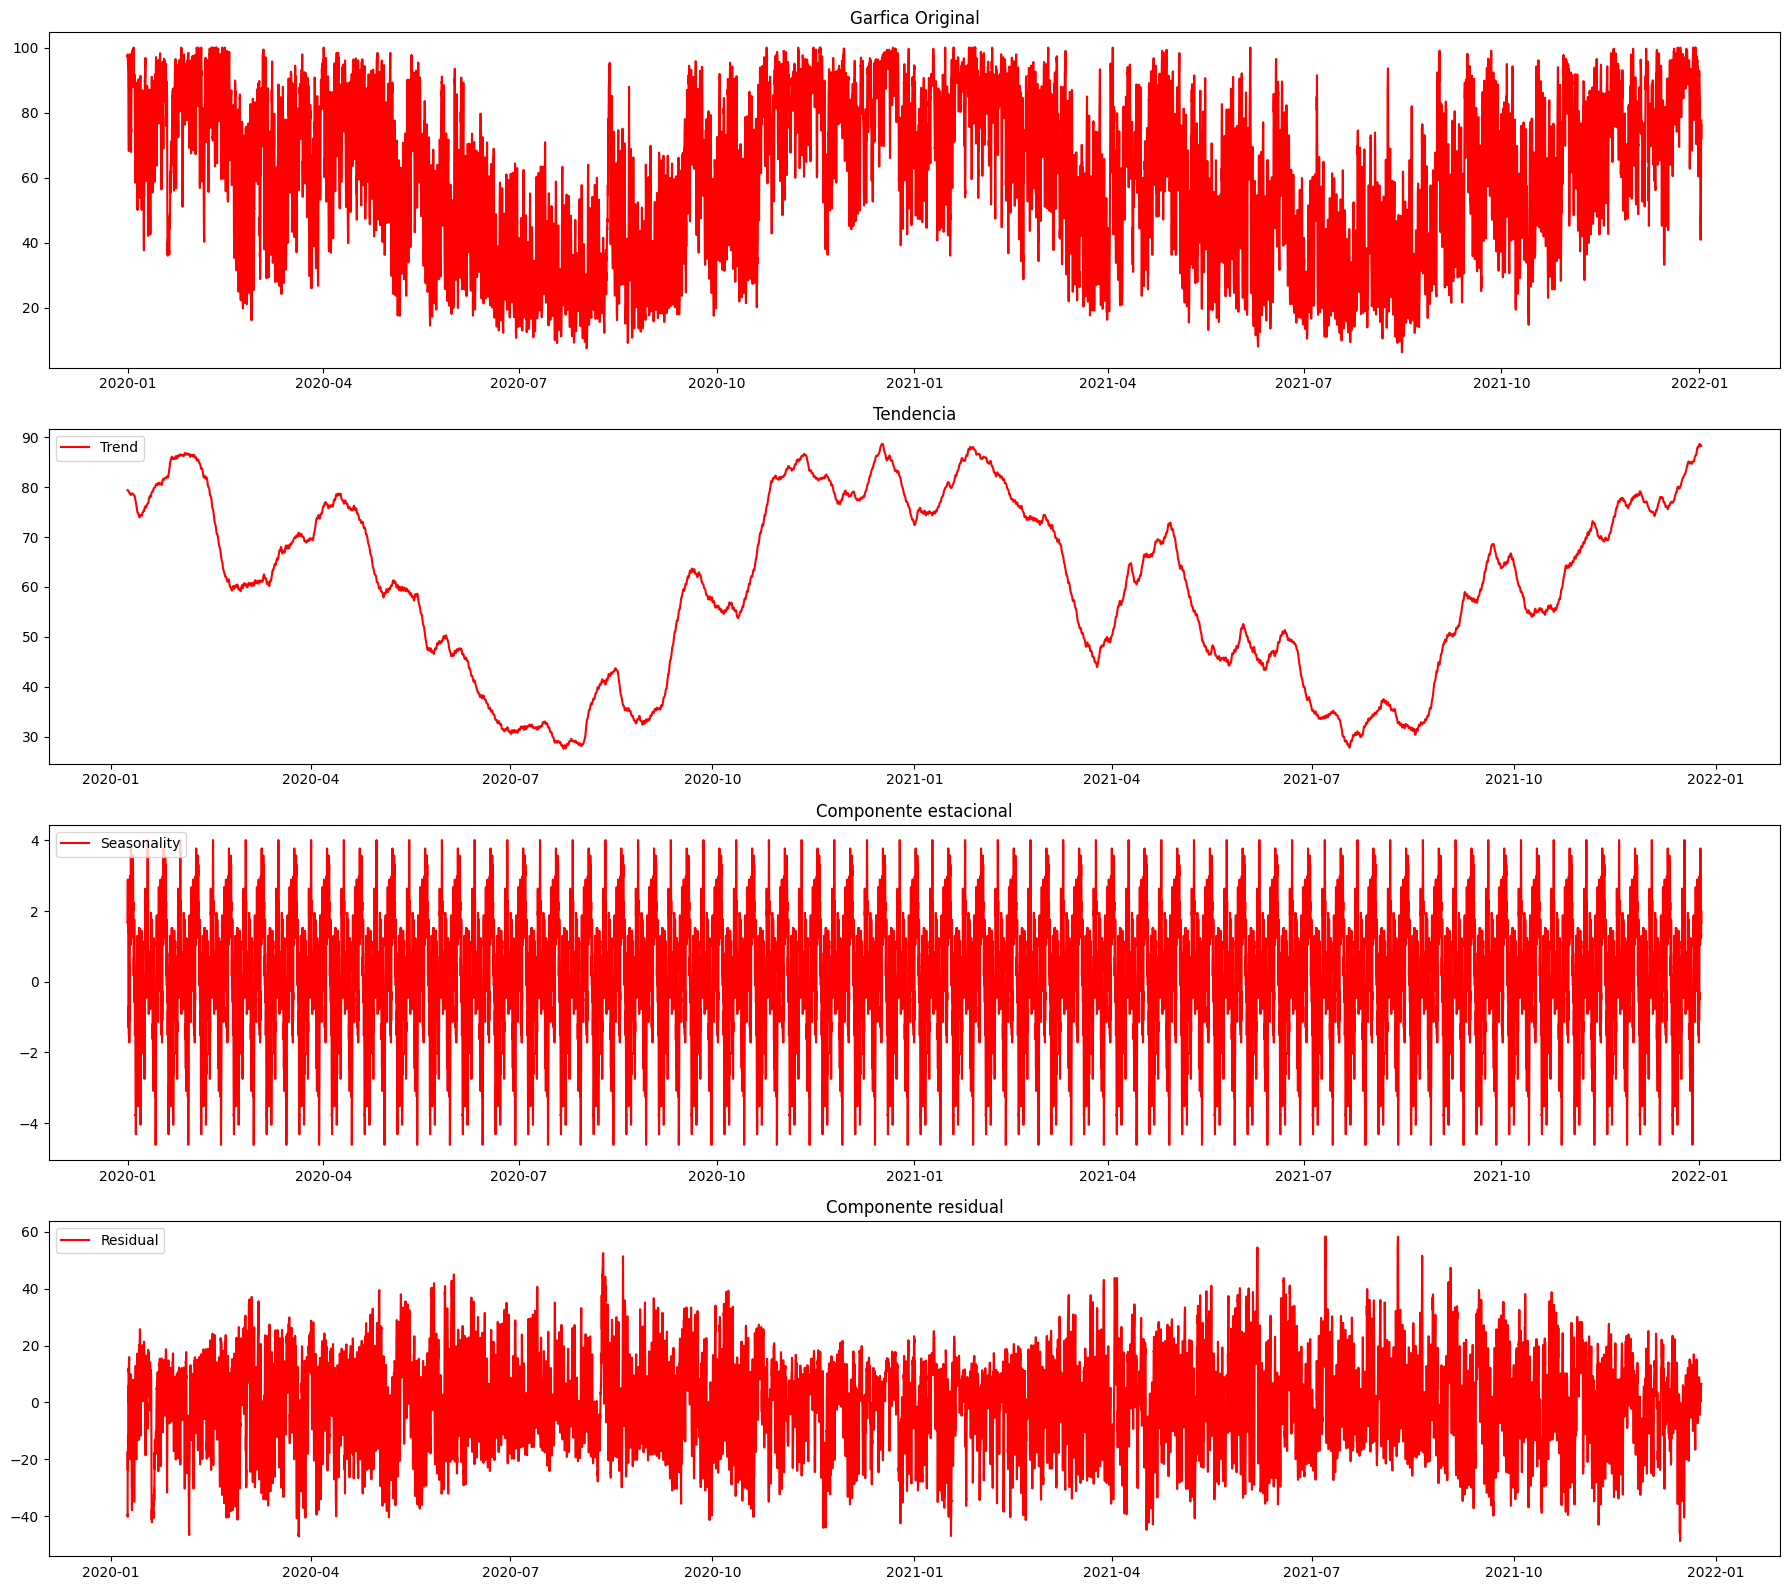

In [13]:
# Descomponer la serie temporal de la humedad relativa para mostrar la tendencia, estacionalidad y residuos
decomposition_temp = seasonal_decompose(df["relative_humidity_2m"], model='additive', period=365)


plt.figure(figsize=(18, 16))

plt.subplot(4, 1, 1)
plt.plot(df["date"], df["relative_humidity_2m"], color="red")
plt.title('Garfica Original')

plt.subplot(4, 1, 2)
plt.plot(df["date"], decomposition_temp.trend, label='Trend', color="red")
plt.legend(loc='upper left')
plt.title('Tendencia')

plt.subplot(4, 1, 3)
plt.plot(df["date"], decomposition_temp.seasonal, label='Seasonality', color="red")
plt.legend(loc='upper left')
plt.title('Componente estacional')

plt.subplot(4, 1, 4)
plt.plot(df["date"], decomposition_temp.resid, label='Residual', color="red")
plt.legend(loc='upper left')
plt.title('Componente residual')

plt.tight_layout()
plt.show()

### DETECCIÓN DE OUTLIERS MEDIANTE EL FILTRO HAMPEL

- Detecta los outliers dentro de una ventana utlizando la mediana ya que la mediana no suele ser muy afectada por outliers.

In [14]:
window_size=30
n_sigma=3

#Calculate the median in a rolling centered window
rolling_median = df["relative_humidity_2m"].rolling(window_size, center=True).median()

#Calculate the median of the absolute deviations from the data’s median in a rolling centered window
mad = df["relative_humidity_2m"].rolling(window_size, center=True).apply(median_abs_deviation)

#Treshold 
threshold_min = rolling_median - n_sigma*mad
threshold_max = rolling_median + n_sigma*mad

df["outlier_hm"] = (np.abs(df["relative_humidity_2m"] - rolling_median) > n_sigma*mad)

- Outliers del año 2020.

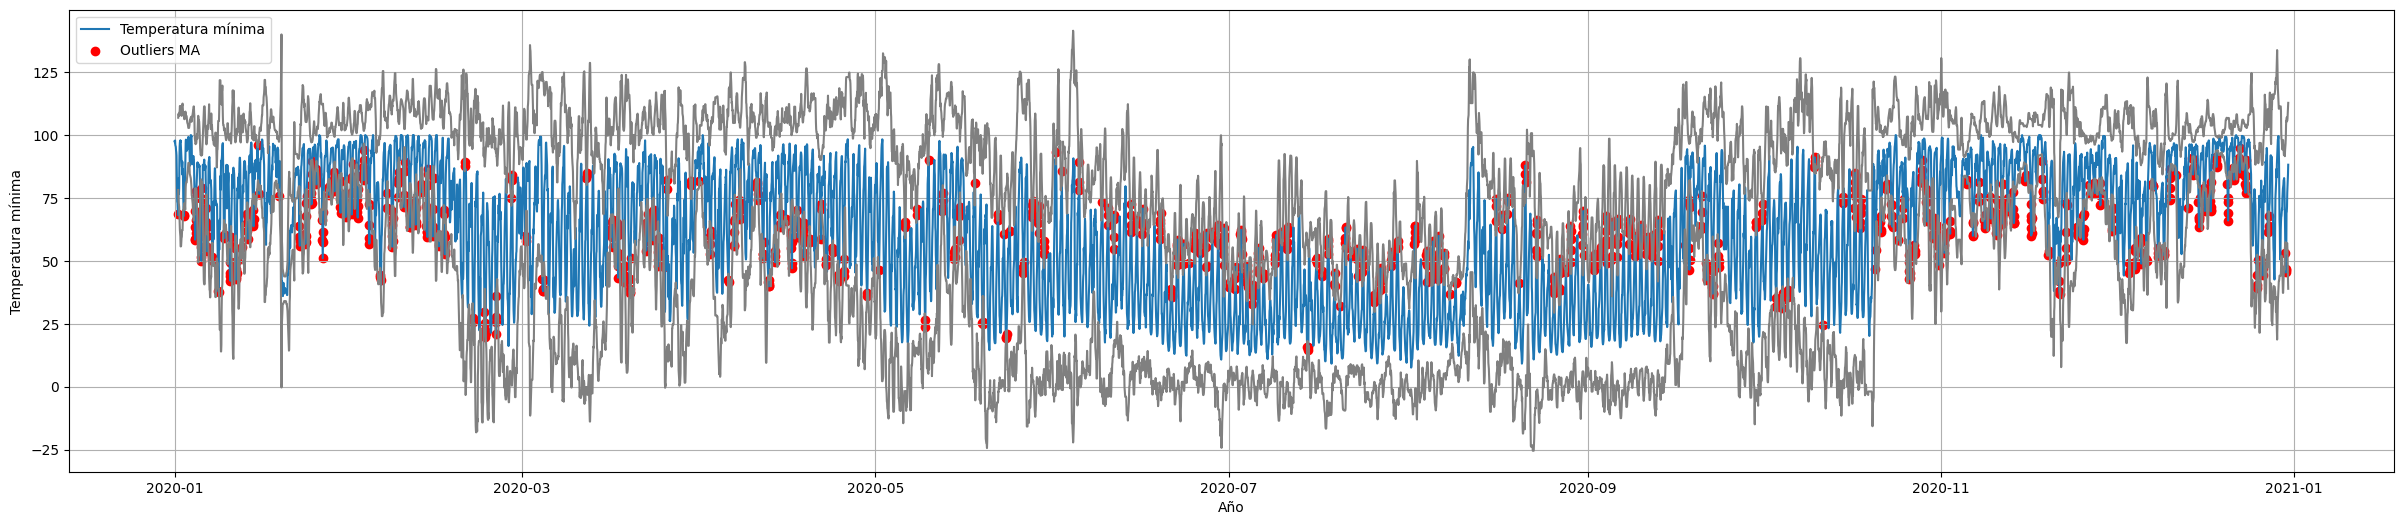

In [15]:

plt.figure(figsize=(30, 6))

primer_año = df.loc[df["date"] <= "2020-12-31"]
plt.plot(primer_año['date'], primer_año['relative_humidity_2m'], label='Temperatura mínima')
plt.plot(primer_año['date'], threshold_min[:8761], color='gray')
plt.plot(primer_año['date'], threshold_max[:8761], color='gray')

plt.scatter(primer_año["date"][df["outlier_hm"]], primer_año["relative_humidity_2m"][primer_año["outlier_hm"]], color='red', label="Outliers MA")
plt.xlabel('Año')
plt.ylabel('Temperatura mínima')
plt.legend()
plt.grid(True)
plt.show()


- Outliers del año 2021.

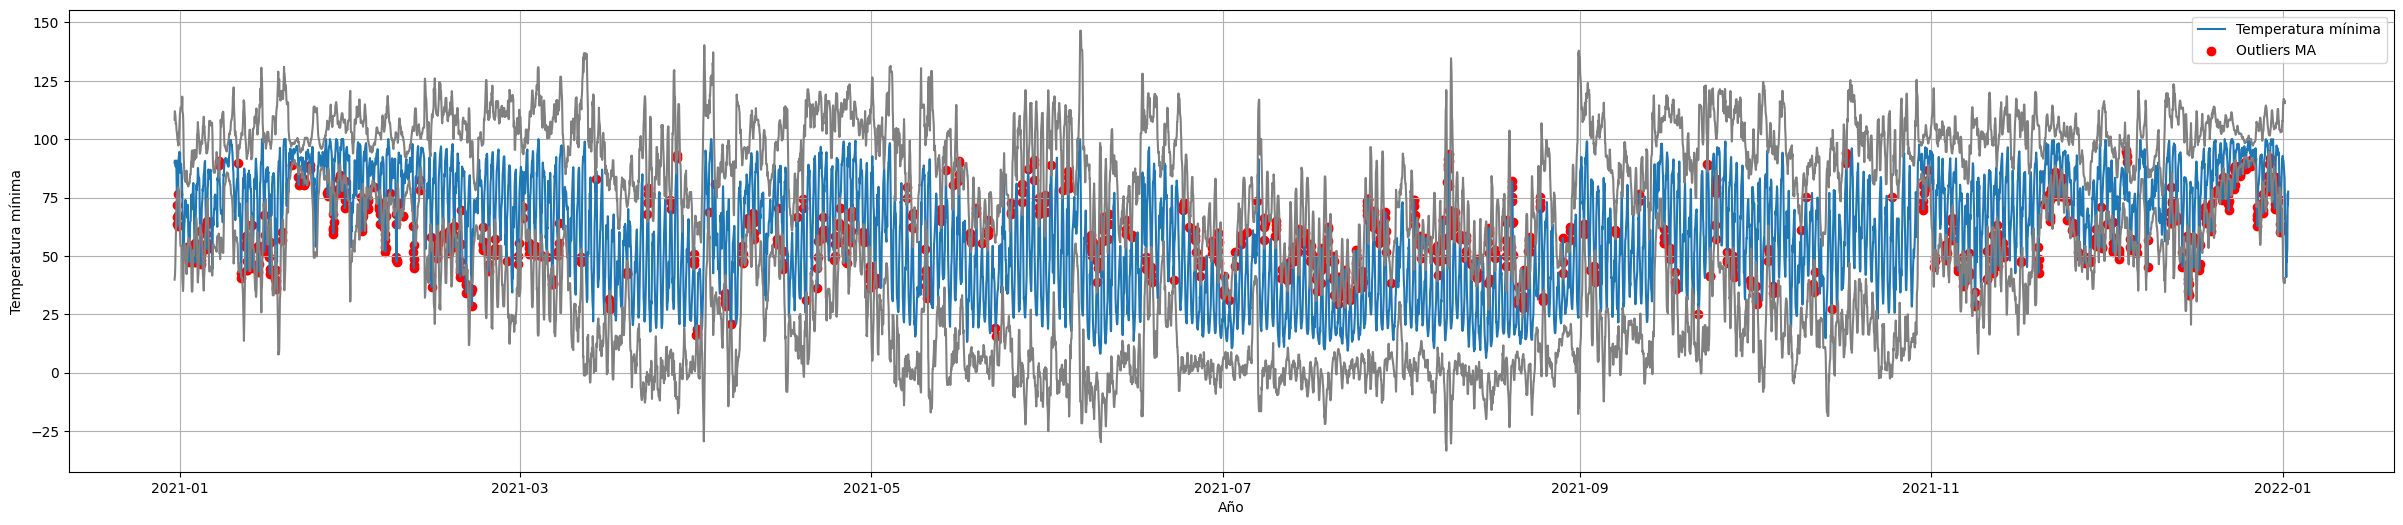

In [16]:
plt.figure(figsize=(30, 6))

segundo_año = df.loc[df["date"] > "2020-12-31"]
plt.plot(segundo_año['date'], segundo_año['relative_humidity_2m'], label='Temperatura mínima')
plt.plot(segundo_año['date'], threshold_min[8761:], color='gray')
plt.plot(segundo_año['date'], threshold_max[8761:], color='gray')

plt.scatter(segundo_año["date"][df["outlier_hm"]], segundo_año["relative_humidity_2m"][segundo_año["outlier_hm"]], color='red', label="Outliers MA")
plt.xlabel('Año')
plt.ylabel('Temperatura mínima')
plt.legend()
plt.grid(True)
plt.show()


- Se detectan los outliers y se les imputa el valor calculado anteriormente, que esta representado como la linea gris.

In [17]:
# Imputar los outliers para que no superen el umbral
df["hr_imputed"] = df["relative_humidity_2m"].copy()  # Copiar la columna original

# Reemplazar valores por debajo del umbral mínimo con el umbral mínimo
df.loc[df["relative_humidity_2m"] < threshold_min, "hr_imputed"] = threshold_min

# Reemplazar valores por encima del umbral máximo con el umbral máximo
df.loc[df["relative_humidity_2m"] > threshold_max, "hr_imputed"] = threshold_max

- Muestra de 6 meses donde se ve los valores que se han imputado.

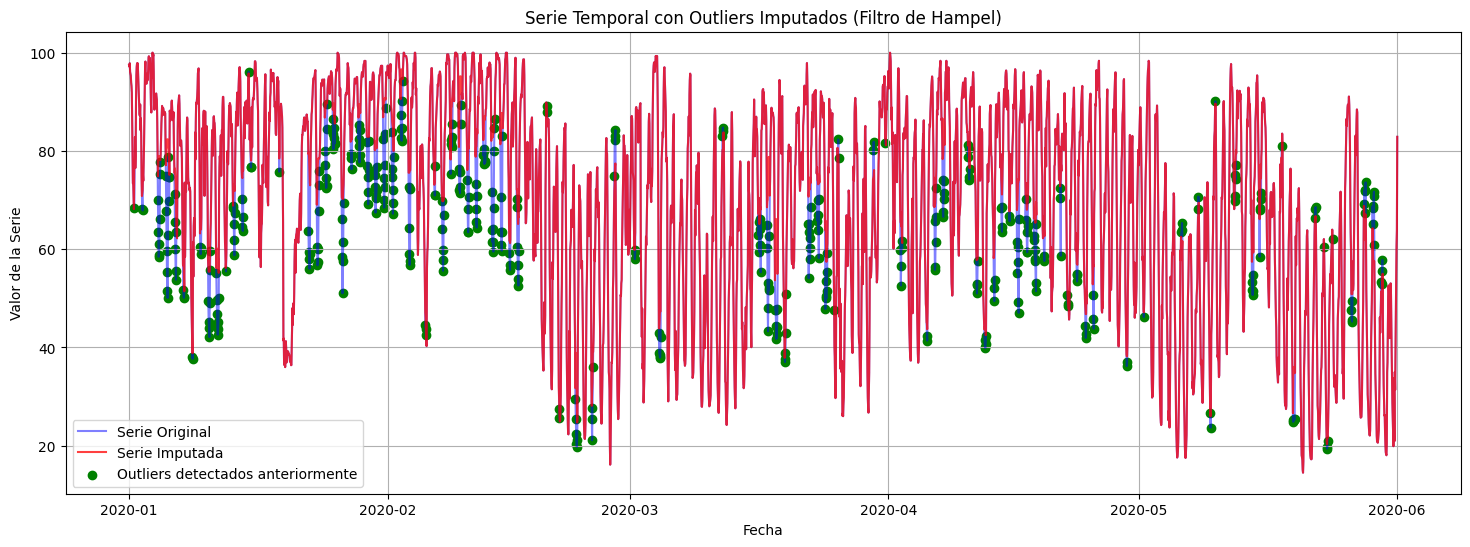

In [18]:
# Muestra de 6 meses
plt.figure(figsize=(18, 6))

mitad_2020 = df.loc[df["date"] <= "2020-06-01"]
# Serie temporal original
plt.plot(mitad_2020["date"], mitad_2020["relative_humidity_2m"], label="Serie Original", color="blue", alpha=0.5)

# Serie temporal con outliers imputados
plt.plot(mitad_2020["date"], mitad_2020["hr_imputed"], label="Serie Imputada", color="red", alpha=0.75)

# Valores atípicos
outliers = mitad_2020[mitad_2020["outlier_hm"]]
plt.scatter(outliers["date"], outliers["relative_humidity_2m"], color="green", label="Outliers detectados anteriormente")


plt.title("Serie Temporal con Outliers Imputados (Filtro de Hampel)")
plt.xlabel("Fecha")
plt.ylabel("Valor de la Serie")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
df["hr"] = df["hr_imputed"]
df.drop(columns=["outlier_hm","hr_imputed","relative_humidity_2m"], inplace = True)

### Comprobar si los datos son estacionarios

- El test de dickey duller detecta si existe una raíz unitaria en la serie temporal. Si la hay significa que no es estacionaria.

In [20]:
# Realizar el Test ADF (Dickey-Fuller Aumentado)
adf_result = adfuller(df["hr"])

# Imprimir los resultados del test ADF
print("Estadística de prueba ADF:", adf_result[0])
print("Valor p:", adf_result[1])
print("Valores críticos:", adf_result[4])
# Interpretación del resultado
if adf_result[1] < 0.05:
    print("Rechazamos la hipótesis nula: La serie es estacionaria")
else:
    print("No podemos rechazar la hipótesis nula: La serie tiene una raíz unitaria y no es estacionaria")

Estadística de prueba ADF: -4.829772619039722
Valor p: 4.768507240275439e-05
Valores críticos: {'1%': -3.430723238497956, '5%': -2.861704957013964, '10%': -2.5668578023342805}
Rechazamos la hipótesis nula: La serie es estacionaria


In [ ]:
base_dir = os.getcwd()
ruta_path = os.path.join(
    base_dir, "..", "data", "homogeneized","Madrid", "datos_Madrid_homogenizados.csv"
)
df.to_csv(ruta_path, index=False)